Skipping corrupted image: C:\Users\Shivansh\OneDrive\Desktop\M.Tech\SEM 2\Machine Learning\PROJECT\Human Emotions dataset\6 Emotions for image classification\disgust\depositphotos_210198264-stock-photo-beautiful-young-hispanic-woman-wearing.jpg
Skipping corrupted image: C:\Users\Shivansh\OneDrive\Desktop\M.Tech\SEM 2\Machine Learning\PROJECT\Human Emotions dataset\6 Emotions for image classification\disgust\depositphotos_255961840-stock-photo-beautiful-young-african-american-woman.jpg
Skipping corrupted image: C:\Users\Shivansh\OneDrive\Desktop\M.Tech\SEM 2\Machine Learning\PROJECT\Human Emotions dataset\6 Emotions for image classification\disgust\depositphotos_390236786-stock-photo-young-beautiful-woman-wearing-casual.jpg
Skipping corrupted image: C:\Users\Shivansh\OneDrive\Desktop\M.Tech\SEM 2\Machine Learning\PROJECT\Human Emotions dataset\6 Emotions for image classification\disgust\depositphotos_467329060-stock-photo-african-american-woman-wearing-casual.jpg
Skipping corrupted imag

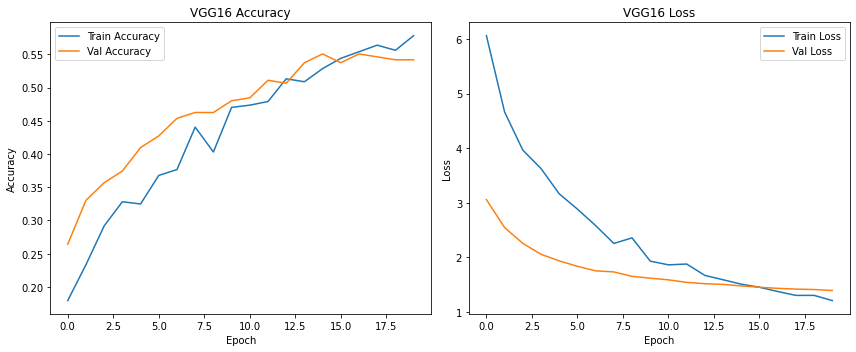

8/8 [==============================] - 19s 2s/step


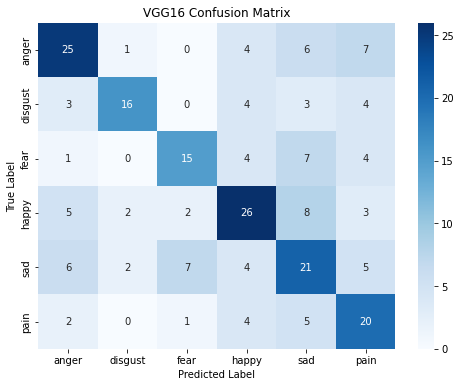


VGG16 Classification Report:
              precision    recall  f1-score   support

       anger       0.60      0.58      0.59        43
     disgust       0.76      0.53      0.63        30
        fear       0.60      0.48      0.54        31
       happy       0.57      0.57      0.57        46
         sad       0.42      0.47      0.44        45
        pain       0.47      0.62      0.53        32

    accuracy                           0.54       227
   macro avg       0.57      0.54      0.55       227
weighted avg       0.56      0.54      0.54       227



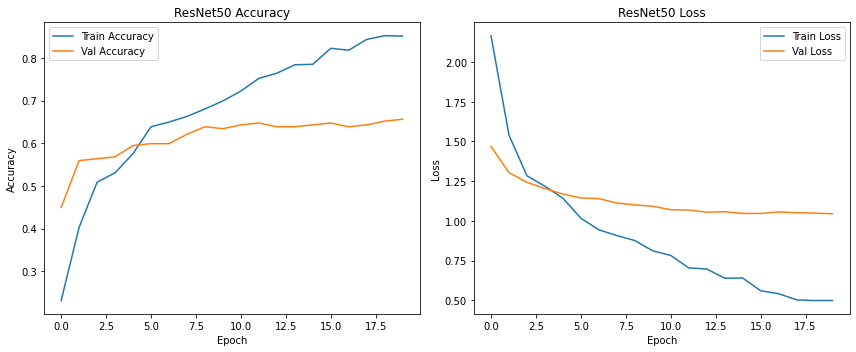

8/8 [==============================] - 14s 2s/step


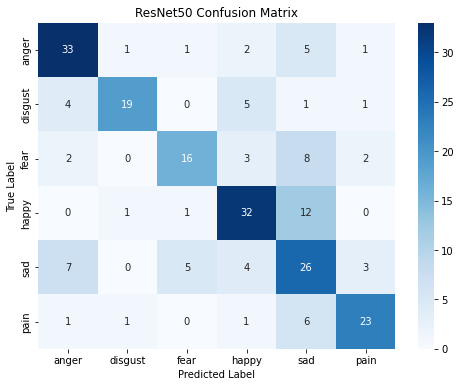


ResNet50 Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.77      0.73        43
     disgust       0.86      0.63      0.73        30
        fear       0.70      0.52      0.59        31
       happy       0.68      0.70      0.69        46
         sad       0.45      0.58      0.50        45
        pain       0.77      0.72      0.74        32

    accuracy                           0.66       227
   macro avg       0.69      0.65      0.67       227
weighted avg       0.68      0.66      0.66       227



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



dataset_path = 'C:\\Users\\Shivansh\\OneDrive\\Desktop\\M.Tech\\SEM 2\\Machine Learning\\PROJECT\\Human Emotions dataset\\6 Emotions for image classification'
emotions = ['anger', 'disgust', 'fear', 'happy', 'sad', 'pain']  

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TEST_SIZE = 0.2
SEED = 42

# Create file paths and labels with image validation
def is_valid_image(filepath):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return os.path.splitext(filepath)[1].lower() in valid_extensions

file_paths = []
labels = []

for emotion_idx, emotion in enumerate(emotions):
    emotion_path = os.path.join(dataset_path, emotion)
    for img_file in os.listdir(emotion_path):
        full_path = os.path.join(emotion_path, img_file)
        if is_valid_image(full_path):
            try:
                # Verify image can be opened
                img = tf.io.read_file(full_path)
                img = tf.image.decode_image(img, channels=3)
                file_paths.append(full_path)
                labels.append(emotion_idx)
            except:
                print(f"Skipping corrupted image: {full_path}")

# Split into train and test
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=TEST_SIZE, random_state=SEED, stratify=labels
)



def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, label

def create_dataset(files, labels):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_files, train_labels)
test_ds = create_dataset(test_files, test_labels)



def build_model(base_model, model_name):
    base_model.trainable = False  # Freeze base model
        
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(emotions), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"\n{model_name} Summary:")
    model.summary()
    return model


vgg_model = build_model(VGG16(weights='imagenet', include_top=False), "VGG16")


resnet_model = build_model(ResNet50(weights='imagenet', include_top=False), "ResNet50")



callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

print("\nTraining VGG16...")
vgg_history = vgg_model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=callbacks
)

print("\nTraining ResNet50...")
resnet_history = resnet_model.fit(
    train_ds,
    epochs=20,
    validation_data=test_ds,
    callbacks=callbacks
)



def evaluate_model(model, history, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    y_pred = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(test_labels, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotions, 
                yticklabels=emotions)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"\n{model_name} Classification Report:")
    print(classification_report(test_labels, y_pred_classes, target_names=emotions))

evaluate_model(vgg_model, vgg_history, "VGG16")
evaluate_model(resnet_model, resnet_history, "ResNet50")